In [1]:
# https://github.com/Kaushalya/medclip/blob/master/tools/test_clip.ipynb
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from jax.config import config
config.update("jax_platform_name", "cpu")
import jax
import sys
import numpy as np
import tensorrt
from transformers import AutoTokenizer, CLIPProcessor
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms import Resize, Normalize, ConvertImageDtype, ToTensor

sys.path.append('..')
from medclip.configuration_hybrid_clip import HybridCLIPConfig
from medclip.modeling_hybrid_clip import FlaxHybridCLIP
from medclip.run_medclip import Transform

ROCO_00031.jpg
['breast man scan', 'breast woman scan', 'lung man scan', 'lung woman scan']
test [[  102  3479   508  6242   103     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [  102  3479 10221  6242   103     0     0     0     0     0     0     0
      0     0     0     0     0     0 

FlaxCLIPOutput(logits_per_image=Array([[1.090851 , 1.241507 , 0.6195761, 0.8033548]], dtype=float32), logits_per_text=Array([[1.090851 ],
       [1.241507 ],
       [0.6195761],
       [0.8033548]], dtype=float32), text_embeds=Array([[-0.02670277, -0.00328178, -0.04799343, ...,  0.05047999,
        -0.04854589, -0.01369414],
       [-0.02558849, -0.00346057, -0.04521635, ...,  0.05142097,
        -0.04653503, -0.01335753],
       [-0.03110847, -0.00259783, -0.05249416, ...,  0.04821953,
        -0.06427244, -0.01923642],
       [-0.02973885, -0.00258212, -0.04951632, ...,  0.04936172,
        -0.06240533, -0.01842892]], dtype=float32), image_embeds=Array([[-1.19542778e-02,  1.66579913e-02,  2.74205189e-02,
        -6.56801015e-02,  5.16676530e-02, -1.49055431e-02,
        -3.95976640e-02,  7.44703051e-04,  3.65558900e-02,
        -5.16428351e-02,  1.48264435e-03, -7.75051862e-02,
        -2.21085902e-02, -3.73689495e-02,  2.12878808e-02,
        -1.90746156e-04, -5.30947559e-02, -7.831

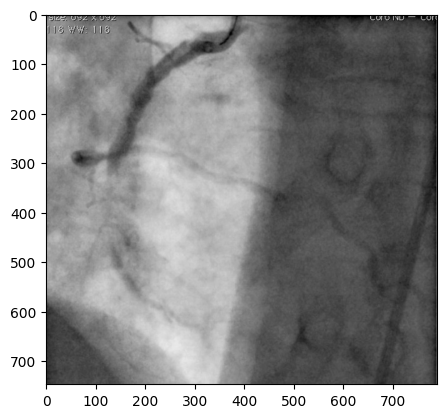

In [59]:
# tokenizer_name = "allenai/scibert_scivocab_uncased"
# config = HybridCLIPConfig.from_pretrained("../..")
# model = FlaxHybridCLIP.from_pretrained("flax-community/medclip-roco")
model = FlaxHybridCLIP.from_pretrained("../Experiments/snapshots/vision_augmented_biobert/")
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
vision_model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(vision_model_name)

import os
img_dir = '../Experiments/test/'
query = 'lung'
classes = ['man', 'woman']
img_path = os.listdir(img_dir)[0]
# img_path = "ROCO_00001.jpg"
caption = "Axial MRI (coronal view)."
print(img_path)
# Let's load a sample image
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
plt.imshow(img, aspect='equal', cmap='gray')

organs = ['breast', 'lung']
class_text = [f'{c} scan' for c in classes]
sentences = [f'{organ} {t}' for organ in organs for t in class_text]
print(sentences)
sentences = ['breast man scan', 'breast woman scan', 'lung man scan', 'lung woman scan']

img_transforms = Transform(image_size=224)
pixel_values = img_transforms(torchvision.transforms.functional.pil_to_tensor(img)).numpy()
pixel_values = pixel_values.transpose((1, 2, 0))
pixel_values = pixel_values[np.newaxis, ...]
input_toks = tokenizer(sentences, max_length=128, padding="max_length", return_tensors="np",
                    truncation=True)
inputs = {'pixel_values': pixel_values, 'input_ids': input_toks['input_ids']}
print(f'test {inputs["input_ids"]}')
outputs = model(**inputs)
outputs

In [19]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
token = tokenizer.decode([ 0,7805,  1988  , 313 ,14194 ,    2  ,   1   ,  1 ,    1  ])
print(token)

tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
token = tokenizer.decode([ 102 , 3479  , 508  ,6242  , 103 ,    0    , 0    , 0  ,   0])
print(token)

tokenizer = AutoTokenizer.from_pretrained('openai/clip-vit-large-patch14')
token = tokenizer.decode([49406, 9475,786,11261, 49407])
print(token)

tokenizer = AutoTokenizer.from_pretrained('openai/clip-vit-base-patch32')
token = tokenizer.decode([49406, 9475,786,11261, 49407])
print(token)

<s>breast man scan</s><pad><pad><pad>
[CLS] breast man scan [SEP] [PAD] [PAD] [PAD] [PAD]
<|startoftext|>breast man scan <|endoftext|>
<|startoftext|>breast man scan <|endoftext|>


In [31]:
# model = FlaxHybridCLIP.from_pretrained("flax-community/medclip-roco")
# /mnt/eds_share/Users/yilu.zhou/Development/log/medclip_old/Experiments/roco-dataset/snapshots/vision_augmented_biobert_batch_size=32
model = FlaxHybridCLIP.from_pretrained("flax-community/medclip-roco")
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased") # allenai/scibert_scivocab_uncased
vision_model_name = "openai/clip-vit-base-patch32" #  openai/clip-vit-base-patch32, clip-vit-large-patch14
processor = CLIPProcessor.from_pretrained(vision_model_name)

import os
import json

img_dir = '../Experiments/test/'
img_path = "/mnt/eds_ml/Users/Yilu_ML/roco-dataset/data/test/radiology/images/ROCO_00001.jpg"
# caption = "Axial MRI (coronal view)."
# inputs = processor(text=[query], images=None, return_tensors="jax", padding=True)
# query_vec = model.get_text_features(**inputs)
print(img_path)
# Let's load a sample image
import os, requests
from PIL import Image
import matplotlib.pyplot as plt
# img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
img = Image.open(img_path).convert('RGB')
# plt.imshow(img, aspect='equal', cmap='gray')

# organs = ['breast', 'lung']
# class_text = [f'{c} scan' for c in classes]
# sentences = [f'{organ} {t}' for organ in organs for t in class_text]
sentences = ['CT', 'MRI', 'Xray']
print(sentences)

# inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)
max_length=128
inputs = processor(text=sentences, images=img, return_tensors="jax", padding="max_length", max_length=max_length)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
print(inputs.keys())
input_toks = tokenizer(sentences, max_length=128, padding="max_length", return_tensors="np",
                    truncation=True)
inputs['input_ids'] = input_toks['input_ids']
# print(inputs['input_ids'])
outputs = model(**inputs)
# img_vec = model.get_image_features(**inputs)
# img_vec = np.array(img_vec).reshape(-1)
# img_vec_s = ",".join(["{:.7e}".format(x) for x in img_vec])
# print(img_vec)

/mnt/eds_ml/Users/Yilu_ML/roco-dataset/data/test/radiology/images/ROCO_00001.jpg
['CT', 'MRI', 'Xray']
dict_keys(['input_ids', 'attention_mask', 'pixel_values'])


In [12]:
config = HybridCLIPConfig.from_pretrained("/mnt/eds_share/Users/yilu.zhou/Development/log/medclip/004/")


# model = FlaxHybridCLIP.from_pretrained("flax-community/medclip-roco")
# model = FlaxHybridCLIP.from_pretrained("../Experiments/snapshots/vision_augmented_biobert/")
# model = FlaxHybridCLIP.from_pretrained("/mnt/eds_share/Users/yilu.zhou/Development/log/medclip/004/", config=config)
model = FlaxHybridCLIP.from_pretrained("/mnt/eds_share/Users/yilu.zhou/Development/log/medclip/004/")
# tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
# tokenizer = AutoTokenizer.from_pretrained("/mnt/eds_share/Users/yilu.zhou/Development/log/medclip/004/")
vision_model_name = "/mnt/eds_share/Users/yilu.zhou/Development/log/medclip/004/" #openai/clip-vit-base-patch32, openai/clip-vit-large-patch14
processor = CLIPProcessor.from_pretrained(vision_model_name)
# processor = CLIPProcessor.from_pretrained("/mnt/eds_share/Users/yilu.zhou/Development/log/medclip/004/")

img_dir = '/mnt/eds_ml/Users/Yilu_ML/roco-dataset/data/test/radiology/images'
import os
import json


# query = 'lung'
# classes = ['brain', 'abdomen', 'breast']
# classes = ['mammography', 'CT', 'X-ray', 'ultrasound']
# classes = ['man', 'woman']
# classes = ['malignancy', 'cancer', 'air']

# img_path = os.listdir(img_dir)[0]
img_path = os.path.join(img_dir, 'ROCO_00001.jpg')
# caption = "Axial MRI (coronal view)."
# inputs = processor(text=[query], images=None, return_tensors="jax", padding=True)
# query_vec = model.get_text_features(**inputs)
print(img_path)
# Let's load a sample image
import os, requests
from PIL import Image
import matplotlib.pyplot as plt
# img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
img = Image.open(img_path).convert('RGB')
plt.imshow(img, aspect='equal', cmap='gray')

# organs = ['breast', 'lung']
# class_text = [f'{c} scan' for c in classes]
# sentences = [f'{organ} {t}' for organ in organs for t in class_text]
sentences = ['MRI', 'CT', 'Xray']
print(sentences)

# inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)
max_length=128
inputs = processor(text=sentences, images=img, return_tensors="jax", padding="max_length", max_length=max_length)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
print(inputs.keys())
input_toks = tokenizer(sentences, max_length=128, padding="max_length", return_tensors="np",
                    truncation=True)
inputs['input_ids'] = input_toks['input_ids']
# print(inputs['input_ids'])
outputs = model(**inputs)
# img_vec = model.get_image_features(**inputs)
# img_vec = np.array(img_vec).reshape(-1)
# img_vec_s = ",".join(["{:.7e}".format(x) for x in img_vec])
# print(img_vec)

TODO: clip_vision_model
TODO: self.vision_config = CLIPVisionConfig {
  "attention_dropout": 0.0,
  "dropout": 0.0,
  "hidden_act": "quick_gelu",
  "hidden_size": 1024,
  "image_size": 336,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "model_type": "clip_vision_model",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 14,
  "projection_dim": 768,
  "transformers_version": "4.31.0.dev0"
}

TODO: projection_dim = 768
TODO: clip_vision_model
TODO: self.vision_config = CLIPVisionConfig {
  "attention_dropout": 0.0,
  "dropout": 0.0,
  "hidden_act": "quick_gelu",
  "hidden_size": 1024,
  "image_size": 336,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "model_type": "clip_vision_model",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 14,
  "projection_dim": 768,
  "t

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_311444/1319730950.py:11 in <module>                                        │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_311444/1319730950.py'                │
│ /mnt/eds_share/Users/yilu.zhou/Development/transformers/src/transformers/processing_utils │
│ .py:215 in from_pretrained                                                                │
│                                                                                           │
│   212 │   │   │   # change to `token` in a follow-up PR                                   │
│   213 │   │   │   kwargs["use_auth_token"] = token                                        │
│   214 │   │                                                                               │
│ ❱ 215 │   │   args = cls._get_arguments_from_pretrained(pretrained_model_name_or_path, ** │
│   216 │   │   return cls(*args)                                                           │
│   217 │                                                                                   │
│   218 │   @classmethod                                                                    │
│                                                                                           │
│ /mnt/eds_share/Users/yilu.zhou/Development/transformers/src/transformers/processing_utils │
│ .py:259 in _get_arguments_from_pretrained                                                 │
│                                                                                           │
│   256 │   │   │   else:                                                                   │
│   257 │   │   │   │   attribute_class = getattr(transformers_module, class_name)          │
│   258 │   │   │                                                                           │
│ ❱ 259 │   │   │   args.append(attribute_class.from_pretrained(pretrained_model_name_or_pa │
│   260 │   │   return args                                                                 │
│   261 │                                                                                   │
│   262 │   @property                                                                       │
│                                                                                           │
│ /mnt/eds_share/Users/yilu.zhou/Development/transformers/src/transformers/tokenization_uti │
│ ls_base.py:1830 in from_pretrained                                                        │
│                                                                                           │
│   1827 │   │   │   )                                                                      │
│   1828 │   │                                                                              │
│   1829 │   │   if all(full_file_name is None for full_file_name in resolved_vocab_files.v │
│ ❱ 1830 │   │   │   raise EnvironmentError(                                                │
│   1831 │   │   │   │   f"Can't load tokenizer for '{pretrained_model_name_or_path}'. If y │
│   1832 │   │   │   │   "'https://huggingface.co/models', make sure you don't have a local │
│   1833 │   │   │   │   f"Otherwise, make sure '{pretrained_model_name_or_path}' is the co │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
OSError: Can't load tokenizer for 
'/mnt/eds_share/Users/yilu.zhou/Development/log/medclip/004/'. If you were trying to load it 
from 'https://huggingface.co/models', make sure you don't have a local directory with the 
same name. Otherwise, make sure '/mnt/eds_share/Users/yilu.zhou/Development/log/medclip/004/'
is the correct path to a directory containing all relevant files for a CLIPTokenizerFast 
tokenizer.

In [32]:
print(outputs.logits_per_image)
probs = jax.nn.softmax(outputs.logits_per_image, axis=-1)

for c_name, prob in zip(sentences, probs[0]):
    print(f'{c_name}: {prob:.2f}')

[[-0.4709042   0.13803433 -0.01774259]]
CT: 0.23
MRI: 0.42
Xray: 0.36


In [28]:
model = FlaxHybridCLIP.from_pretrained("flax-community/medclip-roco")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
vision_model_name = "openai/clip-vit-large-patch14" #openai/clip-vit-base-patch32
processor = CLIPProcessor.from_pretrained(vision_model_name)

classes = ['man', 'woman']
organs = ['breast', 'lung']
class_text = [f'{c} scan' for c in classes]
sentences = [f'{organ} {t}' for organ in organs for t in class_text]
print(sentences)

inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
print(inputs.keys())
outputs = model(**inputs)

text_embeds = outputs['text_embeds']
pooler_output = outputs['text_model_output']['pooler_output']
print(inputs['input_ids'])
outputs

['breast man scan', 'breast woman scan', 'lung man scan', 'lung woman scan']
dict_keys(['input_ids', 'attention_mask', 'pixel_values'])
[[49406  9475   786 11261 49407]
 [49406  9475  2308 11261 49407]
 [49406 16271   786 11261 49407]
 [49406 16271  2308 11261 49407]]


FlaxCLIPOutput(logits_per_image=Array([[nan, nan, nan, nan]], dtype=float32), logits_per_text=Array([[nan],
       [nan],
       [nan],
       [nan]], dtype=float32), text_embeds=Array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), image_embeds=Array([[-3.34575213e-02, -8.58176872e-03, -5.30443490e-02,
        -5.72238769e-03, -3.14630158e-02, -3.16442810e-02,
         1.47400079e-02, -1.96863469e-02,  6.35638237e-02,
         1.78805348e-02, -8.30124244e-02,  3.34784668e-03,
        -1.08043803e-02,  2.06726212e-02,  1.31389331e-02,
         3.29391742e-06,  1.64398607e-02,  3.45108099e-02,
        -1.04930568e-02,  1.12700788e-02,  8.62643030e-03,
        -1.27249602e-02,  2.91433409e-02,  2.16146540e-02,
         2.35115569e-02, -1.81173570e-02,  3.12800035e-02,
         1.78128574e-03,  4.98667657e-02, -4.06050310e-03,
        -5.81053607e-02, 

In [37]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# img_path = os.listdir(img_dir)[0]
# # img_path = "ROCO_00001.jpg"
# caption = "Axial MRI (coronal view)."
# # inputs = processor(text=[query], images=None, return_tensors="jax", padding=True)
# # query_vec = model.get_text_features(**inputs)
# print(img_path)
# # Let's load a sample image
# import os, requests
# from PIL import Image
# import matplotlib.pyplot as plt
# image = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
# plt.imshow(image, aspect='equal', cmap='gray')


model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
sentences = ['breast man scan', 'breast woman scan', 'lung man scan', 'lung woman scan'] #["a photo of a cat", "a photo of a dog"]

inputs = processor(text=sentences, images=image, return_tensors="pt", padding=True)
print(inputs.keys())
print(inputs)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


dict_keys(['input_ids', 'attention_mask', 'pixel_values'])
{'input_ids': tensor([[49406,  9475,   786, 11261, 49407],
        [49406,  9475,  2308, 11261, 49407],
        [49406, 16271,   786, 11261, 49407],
        [49406, 16271,  2308, 11261, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]]), 'pixel_values': tensor([[[[ 0.5873,  0.5873,  0.6165,  ...,  0.0617,  0.0471, -0.0259],
          [ 0.5727,  0.5727,  0.6603,  ...,  0.1201,  0.0763,  0.0909],
          [ 0.5873,  0.5435,  0.6165,  ...,  0.0325,  0.1201,  0.0617],
          ...,
          [ 1.8719,  1.8573,  1.8719,  ...,  1.3902,  1.4340,  1.4194],
          [ 1.8281,  1.8719,  1.8427,  ...,  1.4486,  1.4340,  1.5070],
          [ 1.8573,  1.9011,  1.8281,  ...,  1.3756,  1.3610,  1.4486]],

         [[-1.3169, -1.3019, -1.3169,  ..., -1.4970, -1.4369, -1.4820],
          [-1.2418, -1.2718, -1.2268,  ..., -1.4369, -1.4669, -1.4519],
          [-1.25

In [65]:
# processor = CLIPProcessor.from_pretrained(vision_model_name)
# sentences = [f'showing {c} in' for c in classes]
organs = ['breast', 'lung']
class_text = [f'{c} scan' for c in classes]
sentences = [f'{organ} {t}' for organ in organs for t in class_text]
print(sentences)

# max_seq_length = 128
# pixel_values = torch.stack([example[0] for example in examples]).permute(0, 2, 3, 1).numpy()
# pixel_values = torch.stack([example[0] for example in examples]).numpy()
# inputs = tokenizer(sentences, max_length=max_seq_length, padding="max_length", return_tensors="np",
#                     truncation=True)
# batch = {
#         "pixel_values": pixel_values,
#         "input_ids": inputs["input_ids"],
#         "attention_mask": inputs["attention_mask"],
#     }
inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)
max_length=128
# inputs = processor(text=sentences, images=img, return_tensors="jax", padding="max_length", max_length=max_length)
# query_vec = model.get_text_features(**inputs)
# print(f'query_vec={query_vec}')
# inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)
print(inputs['pixel_values'].shape)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
print(inputs['pixel_values'].shape)
print(inputs.keys())
print(inputs['input_ids'].shape)
print(inputs['input_ids'])
# # print(inputs['attention_mask'])
# import pickle
# # Save the list to a file
# with open('input_ids_bad.pkl', 'wb') as f:
#     pickle.dump(inputs['input_ids'], f)

['breast man scan', 'breast woman scan', 'lung man scan', 'lung woman scan']
(1, 3, 224, 224)
(1, 224, 224, 3)
dict_keys(['input_ids', 'attention_mask', 'pixel_values'])
(4, 5)
[[49406  9475   786 11261 49407]
 [49406  9475  2308 11261 49407]
 [49406 16271   786 11261 49407]
 [49406 16271  2308 11261 49407]]


In [8]:
# Load the list from the file
import pickle
with open('input_ids_bad.pkl', 'rb') as f:
    input_ids = pickle.load(f)
print(type(input_ids))
print(input_ids)

<class 'jaxlib.xla_extension.ArrayImpl'>
[[49406  9475   786 11261 49407]
 [49406  9475  2308 11261 49407]
 [49406 16271   786 11261 49407]
 [49406 16271  2308 11261 49407]]


In [8]:
outputs = model(**inputs)
print(outputs.logits_per_image.shape)
# outputs

text_module = <class 'transformers.models.bert.modeling_flax_bert.FlaxBertModule'>
self.logit_scale in setup = 1.1164790391921997
TODO: embedding.shape = (50, 768)
TODO: embedding = [[ 0.00032942 -0.00018357 -0.0001864  ... -0.00100739  0.00169834
  -0.00017751]
 [-0.00099671 -0.00809964 -0.00064721 ...  0.00708622  0.00703227
   0.01037503]
 [ 0.00059166 -0.01127333  0.00715961 ...  0.00276759  0.02541587
  -0.02872863]
 ...
 [-0.00388875  0.00615463  0.00446423 ...  0.00178836  0.01928777
  -0.01686388]
 [ 0.00395448 -0.002493    0.00259616 ...  0.00035157 -0.01550924
   0.01401745]
 [ 0.01355119  0.0007366  -0.00157394 ... -0.00894118  0.00299247
  -0.01602719]]
TODO: inputs = [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49]]
TODO: temp = [[[ 0.00032942 -0.00018357 -0.0001864  ... -0.00100739  0.00169834
   -0.00017751]
  [-0.00099671 -0.00809964 -0.00064721 ...  0.00708622  0

In [21]:
outputs.logits_per_image.shape
outputs

FlaxCLIPOutput(logits_per_image=Array([[-0.09730929, -0.33259112, -0.3435168 , -0.22277613]], dtype=float32), logits_per_text=Array([[-0.09730929],
       [-0.33259112],
       [-0.3435168 ],
       [-0.22277613]], dtype=float32), text_embeds=Array([[-0.04301362, -0.01196294, -0.0335089 , ..., -0.00178267,
         0.08853503, -0.09629273],
       [-0.01951687,  0.01362286,  0.00143771, ...,  0.01275974,
         0.03880923, -0.05906659],
       [-0.08391271, -0.08352026, -0.01316953, ..., -0.03660727,
         0.06732195, -0.04075412],
       [-0.03945412, -0.01419236, -0.03700224, ..., -0.00742388,
         0.08880359, -0.10136661]], dtype=float32), image_embeds=Array([[ 4.33322741e-03,  1.00831147e-02,  7.13292323e-03,
         1.42559316e-02, -5.79362595e-03, -9.66040194e-02,
         8.88383985e-02, -1.03272721e-02,  2.33250242e-02,
        -4.76091914e-02, -5.82611375e-02,  5.81295267e-02,
         5.81024475e-02,  2.61548813e-02,  1.50088351e-02,
         1.28859663e-02, -6.8270

In [20]:
probs = jax.nn.softmax(outputs.logits_per_image, axis=-1)

for c_name, prob in zip(sentences, probs[0]):
    print(f'{c_name}: {prob:.2f}')

breast man scan: 0.29
breast woman scan: 0.23
lung man scan: 0.23
lung woman scan: 0.26


In [3]:
# tokenizer = AutoTokenizer.from_pretrained("roberta-base")
img_transforms = Transform(image_size=224)
pixel_values = img_transforms(torchvision.transforms.functional.pil_to_tensor(img)).numpy()
print(pixel_values.shape)
pixel_values = pixel_values.transpose((1, 2, 0))
print(pixel_values.shape)
pixel_values = pixel_values[np.newaxis, ...]
print(pixel_values.shape)
print(f'sentences={sentences}')
# input_toks = tokenizer(sentences, max_length=128, padding="max_length", return_tensors="np",
#                     truncation=True)
input_toks = tokenizer(sentences, return_tensors="jax",
                    truncation=True)
inputs = {'pixel_values': pixel_values, 'input_ids': input_toks['input_ids']}
# outputs = model(**inputs)
print(inputs.keys())
print(inputs['input_ids'].shape)
print(inputs['input_ids'])
# import pickle
# # Save the list to a file
# with open('input_ids_good.pkl', 'wb') as f:
#     pickle.dump(inputs['input_ids'], f)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 # tokenizer = AutoTokenizer.from_pretrained("roberta-base")                                 │
│    2 img_transforms = Transform(image_size=224)                                                  │
│ ❱  3 pixel_values = img_transforms(torchvision.transforms.functional.pil_to_tensor(img)).nump    │
│    4 print(pixel_values.shape)                                                                   │
│    5 pixel_values = pixel_values.transpose((1, 2, 0))                                            │
│    6 print(pixel_values.shape)                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'img' is not defined

In [7]:
# model = FlaxHybridCLIP.from_pretrained("../Experiments/snapshots/vision_augmented_biobert/")
model = FlaxHybridCLIP.from_pretrained("/mnt/eds_share/Users/yilu.zhou/Development/log/medclip/004/")
tokenizer = AutoTokenizer.from_pretrained("/mnt/eds_share/Users/yilu.zhou/Development/log/medclip/004/") #allenai/scibert_scivocab_uncased
vision_model_name = "/mnt/eds_share/Users/yilu.zhou/Development/log/medclip/004/" #openai/clip-vit-base-patch32, openai/clip-vit-large-patch14
processor = CLIPProcessor.from_pretrained(vision_model_name)

img_dir = '/mnt/eds_ml/Users/Yilu_ML/roco-dataset/data/test/radiology/images/'
max_length=128
# query = 'Coronal plain computed tomography image'
query = 'MRI'
# query = 'tomography'
# sentences = ['Posterioanterior' ,'fluoroscopic' ,'image' ,'lumbosacral' ,'spine']
sentences = [query]
img_list = os.listdir(img_dir)[:10]
print(img_list)
imgs = [Image.open(os.path.join(img_dir, img_path)).convert('RGB') for img_path in img_list]
inputs = processor(text=sentences, images=imgs, return_tensors="jax", padding="max_length", max_length=max_length)
print(inputs.keys())
print(inputs['input_ids'].shape)
# print(inputs['input_ids'])
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
print(inputs['pixel_values'].shape)
# print(inputs['input_ids'])
# input_toks = tokenizer(sentences, max_length=128, padding="max_length", return_tensors="np",
#                     truncation=True)
input_toks = tokenizer(sentences, padding="max_length", max_length=max_length, return_tensors="jax", truncation=True)
inputs['input_ids'] = input_toks['input_ids']
print(inputs['input_ids'].shape)
# print(inputs['input_ids'])
outputs = model(**inputs)

TODO: clip_vision_model
TODO: self.vision_config = CLIPVisionConfig {
  "attention_dropout": 0.0,
  "dropout": 0.0,
  "hidden_act": "quick_gelu",
  "hidden_size": 1024,
  "image_size": 336,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "model_type": "clip_vision_model",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 14,
  "projection_dim": 768,
  "transformers_version": "4.31.0.dev0"
}

TODO: projection_dim = 768


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_311444/4141003168.py:3 in <module>                                         │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_311444/4141003168.py'                │
│ /mnt/eds_share/Users/yilu.zhou/Development/transformers/src/transformers/models/auto/toke │
│ nization_auto.py:659 in from_pretrained                                                   │
│                                                                                           │
│   656 │   │   # If that did not work, let's try to use the config.                        │
│   657 │   │   if config_tokenizer_class is None:                                          │
│   658 │   │   │   if not isinstance(config, PretrainedConfig):                            │
│ ❱ 659 │   │   │   │   config = AutoConfig.from_pretrained(                                │
│   660 │   │   │   │   │   pretrained_model_name_or_path, trust_remote_code=trust_remote_c │
│   661 │   │   │   │   )                                                                   │
│   662 │   │   │   config_tokenizer_class = config.tokenizer_class                         │
│                                                                                           │
│ /mnt/eds_share/Users/yilu.zhou/Development/transformers/src/transformers/models/auto/conf │
│ iguration_auto.py:968 in from_pretrained                                                  │
│                                                                                           │
│   965 │   │   │   _ = kwargs.pop("code_revision", None)                                   │
│   966 │   │   │   return config_class.from_pretrained(pretrained_model_name_or_path, **kw │
│   967 │   │   elif "model_type" in config_dict:                                           │
│ ❱ 968 │   │   │   config_class = CONFIG_MAPPING[config_dict["model_type"]]                │
│   969 │   │   │   return config_class.from_dict(config_dict, **unused_kwargs)             │
│   970 │   │   else:                                                                       │
│   971 │   │   │   # Fallback: use pattern matching on the string.                         │
│                                                                                           │
│ /mnt/eds_share/Users/yilu.zhou/Development/transformers/src/transformers/models/auto/conf │
│ iguration_auto.py:682 in __getitem__                                                      │
│                                                                                           │
│   679 │   │   if key in self._extra_content:                                              │
│   680 │   │   │   return self._extra_content[key]                                         │
│   681 │   │   if key not in self._mapping:                                                │
│ ❱ 682 │   │   │   raise KeyError(key)                                                     │
│   683 │   │   value = self._mapping[key]                                                  │
│   684 │   │   module_name = model_type_to_module_name(key)                                │
│   685 │   │   if module_name not in self._modules:                                        │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'hybrid-clip'

In [22]:
probs = jax.nn.softmax(outputs.logits_per_text, axis=-1)

for img_name, prob in zip(img_list, probs[0]):
    print(f'{img_name}: {prob:.2f}')

ROCO_00031.jpg: 0.11
ROCO_00006.jpg: 0.09
ROCO_00138.jpg: 0.10
ROCO_00061.jpg: 0.09
ROCO_00016.jpg: 0.08
ROCO_01580.jpg: 0.12
ROCO_00153.jpg: 0.09
ROCO_00001.jpg: 0.13
ROCO_00036.jpg: 0.11
ROCO_00025.jpg: 0.08


In [213]:
# Encode a bunch of images using the model
embeddings = []
query = 'abdomen'
image_vec_file = './demo/image_embeddings.tsv'

fvec = open(image_vec_file, "w")
img_list = os.listdir(img_dir)[:20]

for idx, img_path in enumerate(img_list):
    if idx % 20 == 0:
        print(f"{idx} images processed")
    img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
    inputs = processor(images=img, return_tensors="jax", padding=True)
    inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
    img_vec = model.get_image_features(**inputs)
    img_vec = np.array(img_vec).reshape(-1)
    img_vec_s = ",".join(["{:.7e}".format(x) for x in img_vec])
    embeddings.append(np.array(img_vec).reshape(-1))
    fvec.write(f"{img_path}\t{img_vec_s}\n")

fvec.close()


0 images processed


In [212]:
import nmslib
def load_index(embedding_file):
    filenames, image_vecs = [], []
    with open(embedding_file, "r") as fvec:
        for line in fvec:
            cols = line.strip().split('\t')
            filename = cols[0]
            image_vec = np.array([float(x) for x in cols[1].split(',')])
            filenames.append(filename)
            image_vecs.append(image_vec)
    V = np.array(image_vecs)
    index = nmslib.init(method='hnsw', space='cosinesimil')
    index.addDataPointBatch(V)
    index.createIndex({'post': 2}, print_progress=True)
    return filenames, index

In [37]:
max_seq_length = 128
pixel_values = torch.stack([example[0] for example in examples]).permute(0, 2, 3, 1).numpy()
# pixel_values = torch.stack([example[0] for example in examples]).numpy()
captions = [example[1] for example in examples]
inputs = tokenizer(captions, max_length=max_seq_length, padding="max_length", return_tensors="np",
                    truncation=True)
batch = {
        "pixel_values": pixel_values,
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
    }
logits = model(**batch, train=False)[0]

torch.Size([3, 224, 224])

In [71]:
import os
import jax
import sys
import numpy as np
from transformers import AutoTokenizer, CLIPProcessor
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms import Resize, Normalize, ConvertImageDtype, ToTensor

sys.path.append('..')
from medclip.configuration_hybrid_clip import HybridCLIPConfig
from medclip.modeling_hybrid_clip import FlaxHybridCLIP
from medclip.run_medclip import Transform

model = FlaxHybridCLIP.from_pretrained("flax-community/medclip-roco")
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
vision_model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(vision_model_name)

import os
classes = ['man', 'woman']
img_path = '../images/PMC107839_1471-2296-3-6-3.jpg'
caption = " Plain X-ray of the abdomen showing a well-defined, rounded soft tissue density mass, in the central abdominal region with calcification (arrows)."
img = Image.open(img_path)
# plt.imshow(img, aspect='equal', cmap='gray')

sentences = [f'{c} with' for c in classes]
print(sentences)

img_transforms = Transform(image_size=224)
pixel_values = img_transforms(torchvision.transforms.functional.pil_to_tensor(img)).numpy()
pixel_values = pixel_values.transpose((1, 2, 0))
pixel_values = pixel_values[np.newaxis, ...]
input_toks = tokenizer(sentences, max_length=128, padding="max_length", return_tensors="np",
                    truncation=True)
# inputs = {'pixel_values': pixel_values, 'input_ids': input_toks['input_ids']}
# outputs = model(**inputs)


inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)

print(f'{inputs.keys()}')
print(f'{inputs["input_ids"]}')
print(f'{inputs["attention_mask"]}')

['man with', 'woman with']
dict_keys(['input_ids', 'attention_mask', 'pixel_values'])
[[49406   786   593 49407]
 [49406  2308   593 49407]]
[[1 1 1 1]
 [1 1 1 1]]
